# Import Section

In [7]:
# For inline plotting with vector graphics
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Color maps for color-blind friendly visualizations
from tol_colors import tol_cmap, tol_cset

# Standard data handling and numerical libraries
import pandas as pd
import numpy as np
import re
import os

# Plotting library
import matplotlib.pyplot as plt

# Statistical functions and distributions
from scipy.stats import norm, chi2

# Scikit-learn metrics and calibration curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc

In [8]:
# Define the folder name
folder_name = "figures"

# Check if the folder exists; if not, create it
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'figures' already exists.


# Data Loading

In [9]:
# load threshold values
threshold_values = pd.read_csv('model_training/kappa_curve_values.csv')

# load predictions and ground truth
data = np.load('model_evaluation/predictions.npz')
y_pred = data['y_pred']
y_pred_proba = data['y_pred_proba']
y_test = data['y_test']

# Tune Decision Threshold

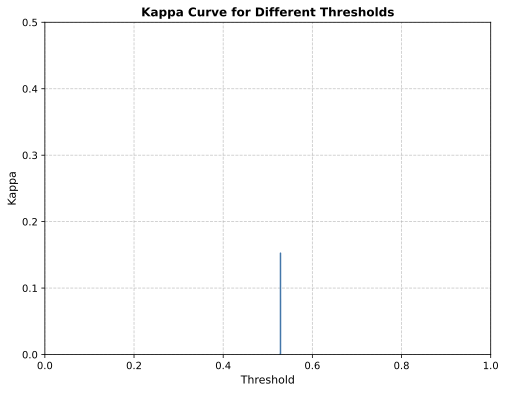

In [10]:
# Set up the figure with APA-style formatting
plt.figure(figsize=(8, 6))

# Plot with tol_cset 'bright' color scheme
cmap = tol_cset('bright')  # Color set for color-blind friendly colors
plt.plot(threshold_values['Threshold'], threshold_values['Kappa'], color=cmap[0])

# Set title and labels
plt.title('Kappa Curve for Different Thresholds', fontsize=12, fontweight='bold')
plt.xlabel('Threshold', fontsize=11)
plt.ylabel('Kappa', fontsize=11)

# Fix x-axis range from 0 to 1
plt.xlim(0, 1)

# Fix y-axis range from 0 to 0.5
plt.ylim(0, 0.5)

# grid and display
plt.grid(True, linestyle='--', alpha=0.7)
# save kappa curve
plt.savefig('figures/kappa_curve_different_thresholds.pdf', format='pdf')
# display kappa curve
plt.show()

# Cross Validation

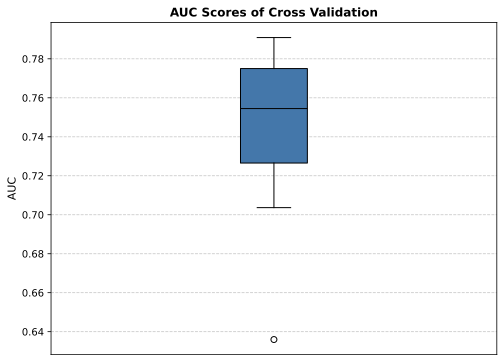

In [11]:
# AUC values for cross validation
auc_values = [
    0.7709950599858857, 0.7909118206385748, 0.7763238916256158, 
    0.7583000000000001, 0.7849639855942376, 0.7036500000000001, 
    0.6359543817527011, 0.7255725572557257, 0.7506265664160401, 
    0.7293229322932293
]

# Set up the figure with APA-style formatting
plt.figure(figsize=(8, 6))

# Define the color-blind friendly color scheme
cmap = tol_cset('bright')

# Create the box plot using the color-blind-friendly color
plt.boxplot(auc_values, patch_artist=True, boxprops=dict(facecolor=cmap[0], color='black'), 
            medianprops=dict(color='black'))

# Set title and labels
plt.title('AUC Scores of Cross Validation', fontsize=12, fontweight='bold')
# Remove x-axis tick labels
plt.xticks([])
plt.ylabel('AUC', fontsize=11)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Save and display the plot
plt.savefig('figures/AUC_scores_cross_validation.pdf', format='pdf')
plt.show()

# Final Model - Membership Functions

In [12]:
# Initialize a list to store extracted information
double_gaussians = []

# Read the file
with open('model_training/Simpful_code.py', 'r') as file:
    lines = file.readlines()

# Regular expressions to match DoubleGaussian_MF functions and concepts
double_gaussian_pattern = re.compile(r'DoubleGaussian_MF\(([-0-9.,\s]+)\)')
concept_pattern = re.compile(r"concept='([\w\d_]+)'")

# Temporary storage for linguistic variables and their DoubleGaussian functions
current_doubles = []
current_concept = None

# Parse each line in reverse to gather DoubleGaussian_MF functions before each concept
for i in range(len(lines) - 1, -1, -1):
    line = lines[i]
    
    # Check if the line contains a concept definition
    concept_match = concept_pattern.search(line)
    if concept_match:
        # Store current concept with its DoubleGaussian functions
        if current_doubles:
            double_gaussians.append({
                'concept': current_concept,
                'DoubleGaussian_MF': current_doubles[::-1]  # Reverse to maintain correct order
            })
        
        # Update current concept and reset function list
        current_concept = concept_match.group(1)
        current_doubles = []
    
    # Check if the line contains a DoubleGaussian_MF function
    double_match = double_gaussian_pattern.search(line)
    if double_match:
        params = list(map(float, double_match.group(1).split(',')))  # Convert to a list of floats
        current_doubles.append(params)

# Capture the last concept and its functions
if current_concept and current_doubles:
    double_gaussians.append({
        'concept': current_concept,
        'DoubleGaussian_MF': current_doubles[::-1]
    })

# Reverse the final list since we processed in reverse order
double_gaussians = double_gaussians[::-1]

# Display the extracted information
for item in double_gaussians:
    print(f"Concept: {item['concept']}")
    print("DoubleGaussian_MF functions:")
    for func in item['DoubleGaussian_MF']:
        print(f"  - {func}")
    print()

Concept: p2674_i0_Category_B
DoubleGaussian_MF functions:
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001925, 2.924883, -0.283831, 0.99286]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001925, 2.924883, -0.283831, 0.99286]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]

Concept: p1920_i0_Category_A
DoubleGaussian_MF functions:
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.001019, 0.421168, -0.28598, 0.995114]
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.00101

In [13]:
# Mapping of concept names to descriptions
concept_mapping = {
    'p2090_i0_Yes': 'Seen doctor (GP) for nerves, anxiety, tension or depression | Yes',
    'p2090_i0_No': 'Seen doctor (GP) for nerves, anxiety, tension or depression | No',
    'p2100_i0_No': 'Seen a psychiatrist for nerves, anxiety, tension or depression | No',
    'p1920_i0_Yes': 'Mood swings | Yes',
    'p1960_i0_No': 'Fed-up feelings | No',
    'p1920_i0_No': 'Mood swings | No',
    'p137_i0': 'Number of treatments/medications taken',
    'p2100_i0_Yes': 'Seen a psychiatrist for nerves, anxiety, tension or depression | Yes',
    'p2050_i0_Not_at_all': 'Frequency of depressed mood in last 2 weeks | Not at all',
    'p1980_i0_Yes': 'Worrier / anxious feelings | Yes'
}

# Add description to each concept in the double_gaussians list
for item in double_gaussians:
    concept_key = item['concept']
    item['Description'] = concept_mapping.get(concept_key, 'Unknown description')

# Display the updated data
for item in double_gaussians:
    print(f"Concept: {item['concept']}")
    print(f"Description: {item['Description']}")
    print("DoubleGaussian_MF functions:")
    for func in item['DoubleGaussian_MF']:
        print(f"  - {func}")
    print()

Concept: p2674_i0_Category_B
Description: Unknown description
DoubleGaussian_MF functions:
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001925, 2.924883, -0.283831, 0.99286]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001925, 2.924883, -0.283831, 0.99286]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]
  - [-0.001573, 0.00148, -0.00217, 2.784825]

Concept: p1920_i0_Category_A
Description: Unknown description
DoubleGaussian_MF functions:
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.001019, 0.421168, -0.28598, 0.995114]
  - [-0.002419, 0.974787, -0.488071, 4.594055]
  - [-0.002419, 0.974787, -0.488071, 4.59

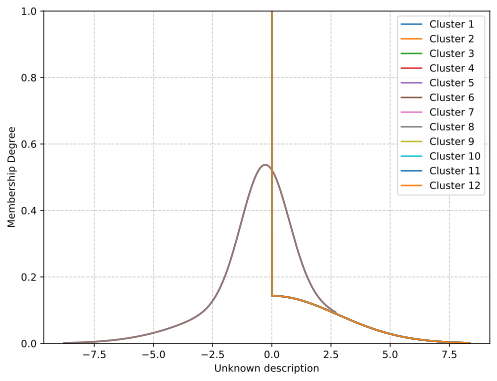

In [14]:
# Function to plot membership degrees for a given concept
def plot_membership_degree(concept_data):
    concept = concept_data['concept']
    description = concept_data.get('Description', 'No description available')
    functions = concept_data['DoubleGaussian_MF']
    
    plt.figure(figsize=(8, 6))

    # Plot each cluster's membership function
    for i, params in enumerate(functions, start=1):
        mean1, stddev1, mean2, stddev2 = params
        
        # Create x values around both Gaussian means
        x = np.linspace(mean1 - 3*stddev1, mean2 + 3*stddev2, 1000)
        
        # Calculate the membership degrees from the two Gaussians
        y1 = norm.pdf(x, mean1, stddev1)
        y2 = norm.pdf(x, mean2, stddev2)
        y = y1 + y2  # Combined effect of both Gaussian curves

        # Plot the membership degree for each cluster
        plt.plot(x, y, label=f'Cluster {i}')

    # Add plot titles and labels
    # plt.title(f'Membership Degree for {concept} - {description}')
    plt.xlabel(description)
    plt.ylabel('Membership Degree')
    plt.ylim(0, 1)  # Limit membership degree to [0, 1] as per typical fuzzy logic standards
    plt.legend()

    # Show the plot
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f'figures/{concept}.pdf', format='pdf')
    plt.show()

# Plot for the first feature
plot_membership_degree(double_gaussians[0])

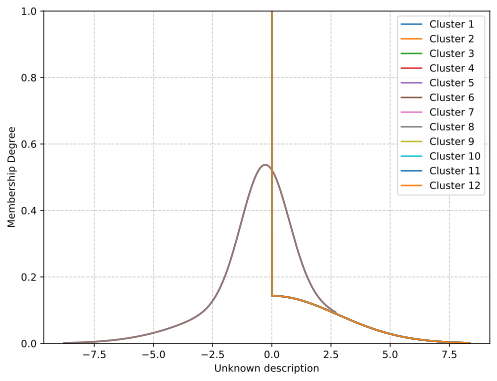

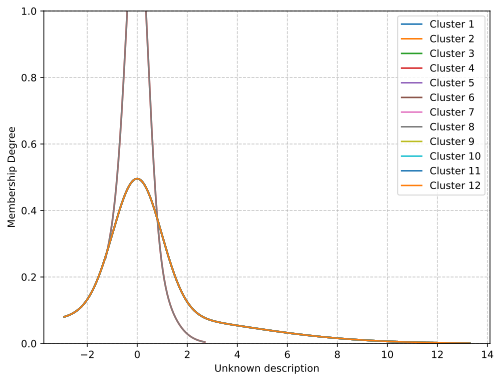

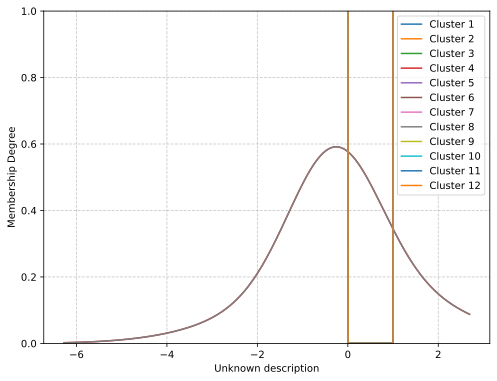

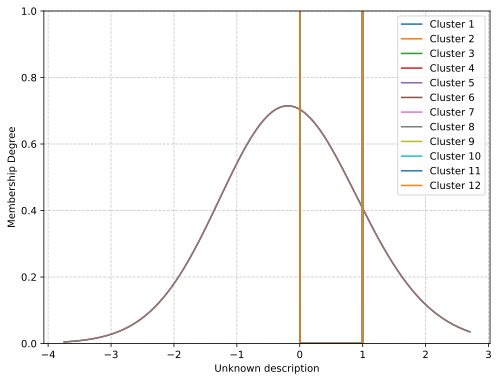

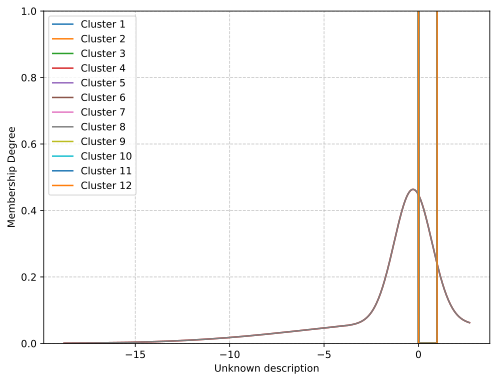

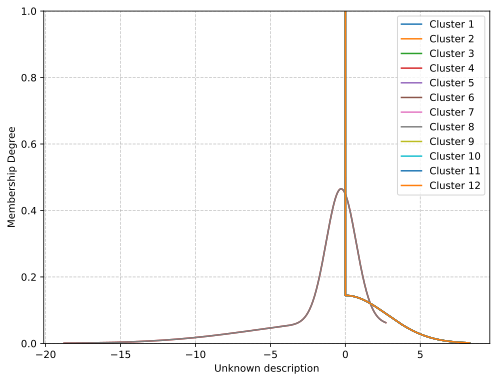

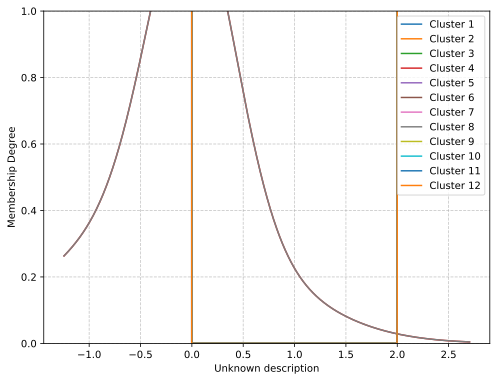

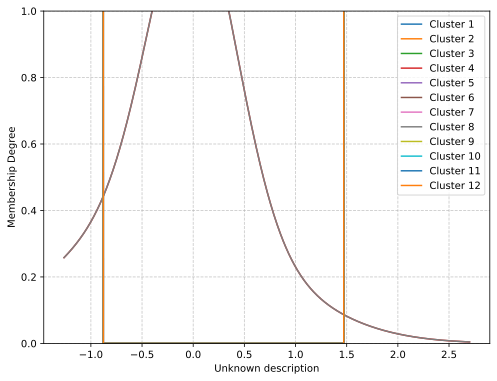

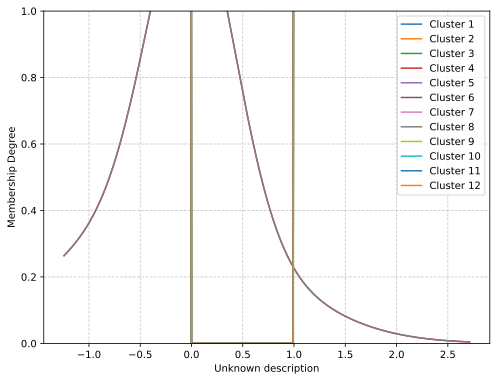

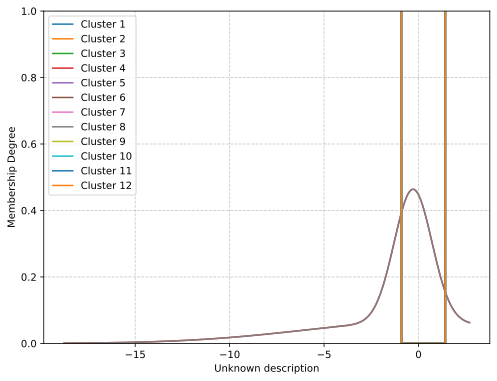

In [15]:
# Plot membership degrees for all features
for concept_data in double_gaussians:
    plot_membership_degree(concept_data)

# Final Model AUC and AUK curves

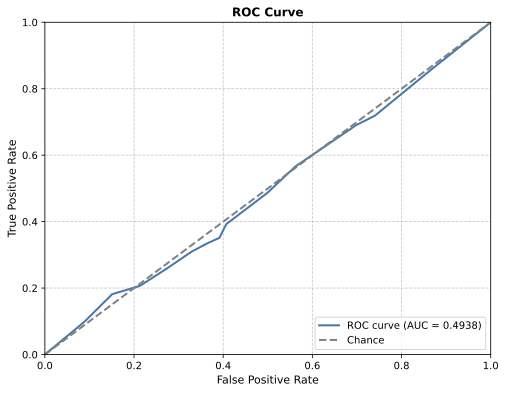

In [16]:
# Compute ROC curve and AUC for y_pred_proba and y_test
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Set up the figure with APA-style formatting
plt.figure(figsize=(8, 6))

# Use tol_bright color scheme
cmap = tol_cset('bright')
plt.plot(fpr, tpr, color=cmap[0], lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')

# Set title and labels
plt.title('ROC Curve', fontsize=12, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)

# Set x-axis and y-axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Enable grid and display legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc="lower right")

# Save the ROC curve as a PDF
plt.savefig('figures/roc_curve.pdf', format='pdf')

# Display the ROC curve
plt.show()

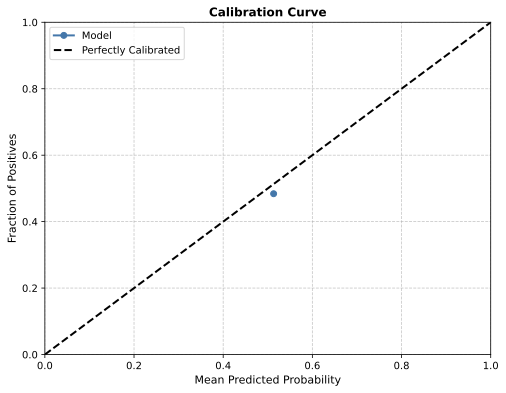

In [17]:
# Calculate the calibration curve (fraction of positives vs. mean predicted probability)
fraction_of_positives, mean_predicted_probabilities = calibration_curve(y_test, y_pred_proba, n_bins=20)

# Set up the figure with APA-style formatting
plt.figure(figsize=(8, 6))

# Use tol_bright color scheme
cmap = tol_cset('bright')

# Plot the calibration curve
plt.plot(mean_predicted_probabilities, fraction_of_positives, marker='o', color=cmap[0], lw=2, label='Model')

# Plot the perfectly calibrated line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfectly Calibrated')

# Set title and labels
plt.title('Calibration Curve', fontsize=12, fontweight='bold')
plt.xlabel('Mean Predicted Probability', fontsize=11)
plt.ylabel('Fraction of Positives', fontsize=11)

# Set x-axis and y-axis limits
plt.xlim([0, 1])
plt.ylim([0, 1])

# Enable grid with APA-style formatting
plt.grid(True, linestyle='--', alpha=0.7)

# Save the calibration curve as a PDF
plt.savefig('figures/calibration_curve.pdf', format='pdf')

# Display the calibration curve
plt.legend()
plt.show()

# Calibration

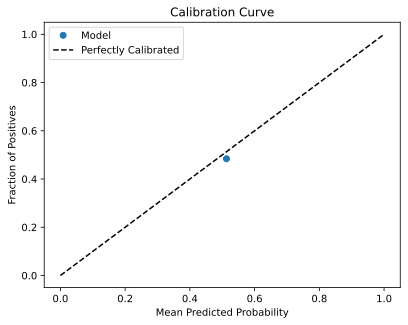

In [18]:
# Calculate the calibration curve (fraction of positives vs. mean predicted probability)
fraction_of_positives, mean_predicted_probabilities = calibration_curve(y_test, y_pred_proba, n_bins=20)

# Plot the calibration curve
plt.plot(mean_predicted_probabilities, fraction_of_positives, marker='o', linestyle='', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [19]:
def hosmer_lemeshow_test(y_true, y_pred_proba, n_bins=10):
    # Step 1: Bin predicted probabilities into n_bins equal-sized bins
    data = np.vstack([y_pred_proba, y_true]).T
    data = data[np.argsort(data[:, 0])]  # Sort by predicted probabilities
    bin_size = len(y_true) // n_bins
    bins = [data[i * bin_size:(i + 1) * bin_size] for i in range(n_bins)]

    # Step 2: Calculate observed and expected frequencies for each bin
    observed_counts = np.array([np.sum(bin[:, 1]) for bin in bins])
    expected_counts = np.array([np.sum(bin[:, 0]) for bin in bins])

    # Step 3: Calculate Hosmer-Lemeshow statistic
    hl_statistic = np.sum((observed_counts - expected_counts) ** 2 / (expected_counts * (1 - expected_counts / bin_size)))

    # Step 4: Calculate p-value using chi-squared distribution with (n_bins - 2) degrees of freedom
    p_value = 1 - chi2.cdf(hl_statistic, n_bins - 2)

    return hl_statistic, p_value

# calcualte Hosmer Lemeshow test
hl_statistic, p_value = hosmer_lemeshow_test(y_test, y_pred_proba)
print(f"Hosmer-Lemeshow statistic: {hl_statistic}")
print(f"P-value: {p_value}")

Hosmer-Lemeshow statistic: 12.407001522493326
P-value: 0.13394730074825478


# create figure for pipeline

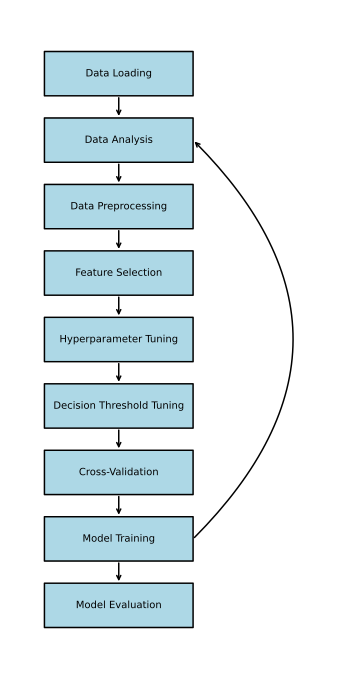

The pipeline diagram with right loop has been saved as: figures/pipeline.pdf


In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 12))
ax.axis("off")

# Helper function to draw a box
def draw_box(ax, text, x, y, width=4, height=1, color="#ADD8E6"):
    rect = mpatches.Rectangle((x - width / 2, y - height / 2), width, height, edgecolor="black", facecolor=color, lw=1.5)
    ax.add_patch(rect)
    ax.text(x, y, text, ha="center", va="center", fontsize=10, color="black")
    return (x, y)

# Labels for the boxes
boxes = [
    "Data Loading", "Data Analysis", "Data Preprocessing", "Feature Selection",
    "Hyperparameter Tuning", "Decision Threshold Tuning",
    "Cross-Validation", "Model Training", "Model Evaluation"
]

# Draw boxes in a vertical line and store their positions
positions = []
for i, label in enumerate(boxes):
    y = -i * 1.5  # Fixed vertical spacing
    positions.append(draw_box(ax, label, 0, y))

# Add arrows between the boxes
for i in range(len(positions) - 1):
    x_start, y_start = positions[i]
    x_end, y_end = positions[i + 1]
    ax.annotate("", xy=(x_end, y_end + 0.5), xytext=(x_start, y_start - 0.5),
                arrowprops=dict(arrowstyle="->", color="black", lw=1.5))

# Add loop-back arrow from "Model Training" to "Data Analysis"
x_start, y_start = positions[-2]  # "Model Training"
x_end, y_end = positions[1]  # "Data Analysis"
loop_x_offset = 2  # Move the loop further to the right
ax.annotate("", xy=(x_end + loop_x_offset, y_end), xytext=(x_start + loop_x_offset, y_start),
            arrowprops=dict(arrowstyle="->", color="black", lw=1.5,
                            connectionstyle="arc3,rad=0.5"))  # Curved arrow bent to the right

# Set axis limits to ensure visibility
ax.set_xlim(-3, 6)
ax.set_ylim(-len(boxes) * 1.5, 1.5)

# Save and show the plot
output_path = "figures/pipeline.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

print(f"The pipeline diagram with right loop has been saved as: {output_path}")